In [1]:
from functions_cfosat_v1 import *
import scipy.special as sps # function erf

In [42]:
# X, Y : grid of wavenumbers = 2 * pi /wavelength
# steps : dkx and dky, with nx and ny values. dkx = 2*pi/(dx*nx)
# x, y : grid of real x,y : nx values with a dx step. 
noise= 0
## ---  physical surface definition
# number of x values
nx = 2048
ny = 2048
dx = 10 # [m]
dy = 10 # [m]

X = np.arange(0,nx*dx,dx) # from 0 to (nx-1)*dx with a dx step
Y = np.arange(0,ny*dy,dy) # from 0 to (ny-1)*dy with a dy step
shx = np.floor(nx/2-1)
shy = np.floor(ny/2-1)
## --- equivalent wavenumber space ----
dkx = 2*np.pi/(dx*nx)
dky = 2*np.pi/(dy*ny)

kX0 = dkx*np.arange(-nx//2+1,nx//2+1)
kY0 = dky*np.arange(-ny//2+1,ny//2+1)
kX,kY = np.meshgrid(kX0, kY0)

## --- read_spectra
theta_m=30
D=1000
T0=14
Hs = 15

## --- 1. Gaussian -------
sk_theta = 0.001
sk_k = 0.001
Z1_Gaussian0,kX,kY=define_Gaussian_spectrum_kxky(kX,kY,T0,theta_m*np.pi/180,sk_theta,sk_k,D=D)
# Z1_Gaussian =(Hs/4)**2*Z1_Gaussian0
Z1_Gaussian =Z1_Gaussian0
sumZ1=4*np.sqrt(sum(Z1_Gaussian.flatten()*dkx*dky)) 
print('Hs for Gaussian : ',sumZ1)

## --- 2. Pierson - Moskowitz -----------------------------
nk=1001
nth=36
k=np.linspace(0.0002,0.2,nk)
thetas=np.linspace(0,360*(nth-1)/nth,nth)*np.pi/180.

Ekth,k,th = define_spectrum_PM_cos2n(k,thetas,T0,theta_m*np.pi/180.,D=D)
Ekxky, kx, ky = spectrum_to_kxky(1,Ekth,k,thetas,D=D)

Z1_PM=spi.griddata((kx.flatten(),ky.flatten()),Ekxky.flatten(),(kX,kY),fill_value=0)
sumZ1=4*np.sqrt(sum(Z1_PM.flatten()*dkx*dky)) 
print('Hs for Pierson Moskowitz : ',sumZ1)

## ----- Extract k spectrum in theta_m direction ----------
kx_vec = k*np.cos(theta_m*np.pi/180)
ky_vec = k*np.sin(theta_m*np.pi/180)

Z1k_PM = spi.griddata((kx.flatten(),ky.flatten()),Ekxky.flatten(),(kx_vec,ky_vec),fill_value=0)

f = spi.interp2d(kX0,kY0,Z1_Gaussian)
Z1k_Gaussian = np.diag(f(kx_vec,ky_vec))

## ----- Obtain surface ----------------------------------
S1_Gaussian,X,Y= surface_from_Z1kxky(Z1_Gaussian,kX,kY)
S1_PM,X,Y= surface_from_Z1kxky(Z1_PM,kX,kY)




Hs for Gaussian :  3.9999999999999964
Hs for Pierson Moskowitz :  7.769907809186016


157549.7991537616
0.0


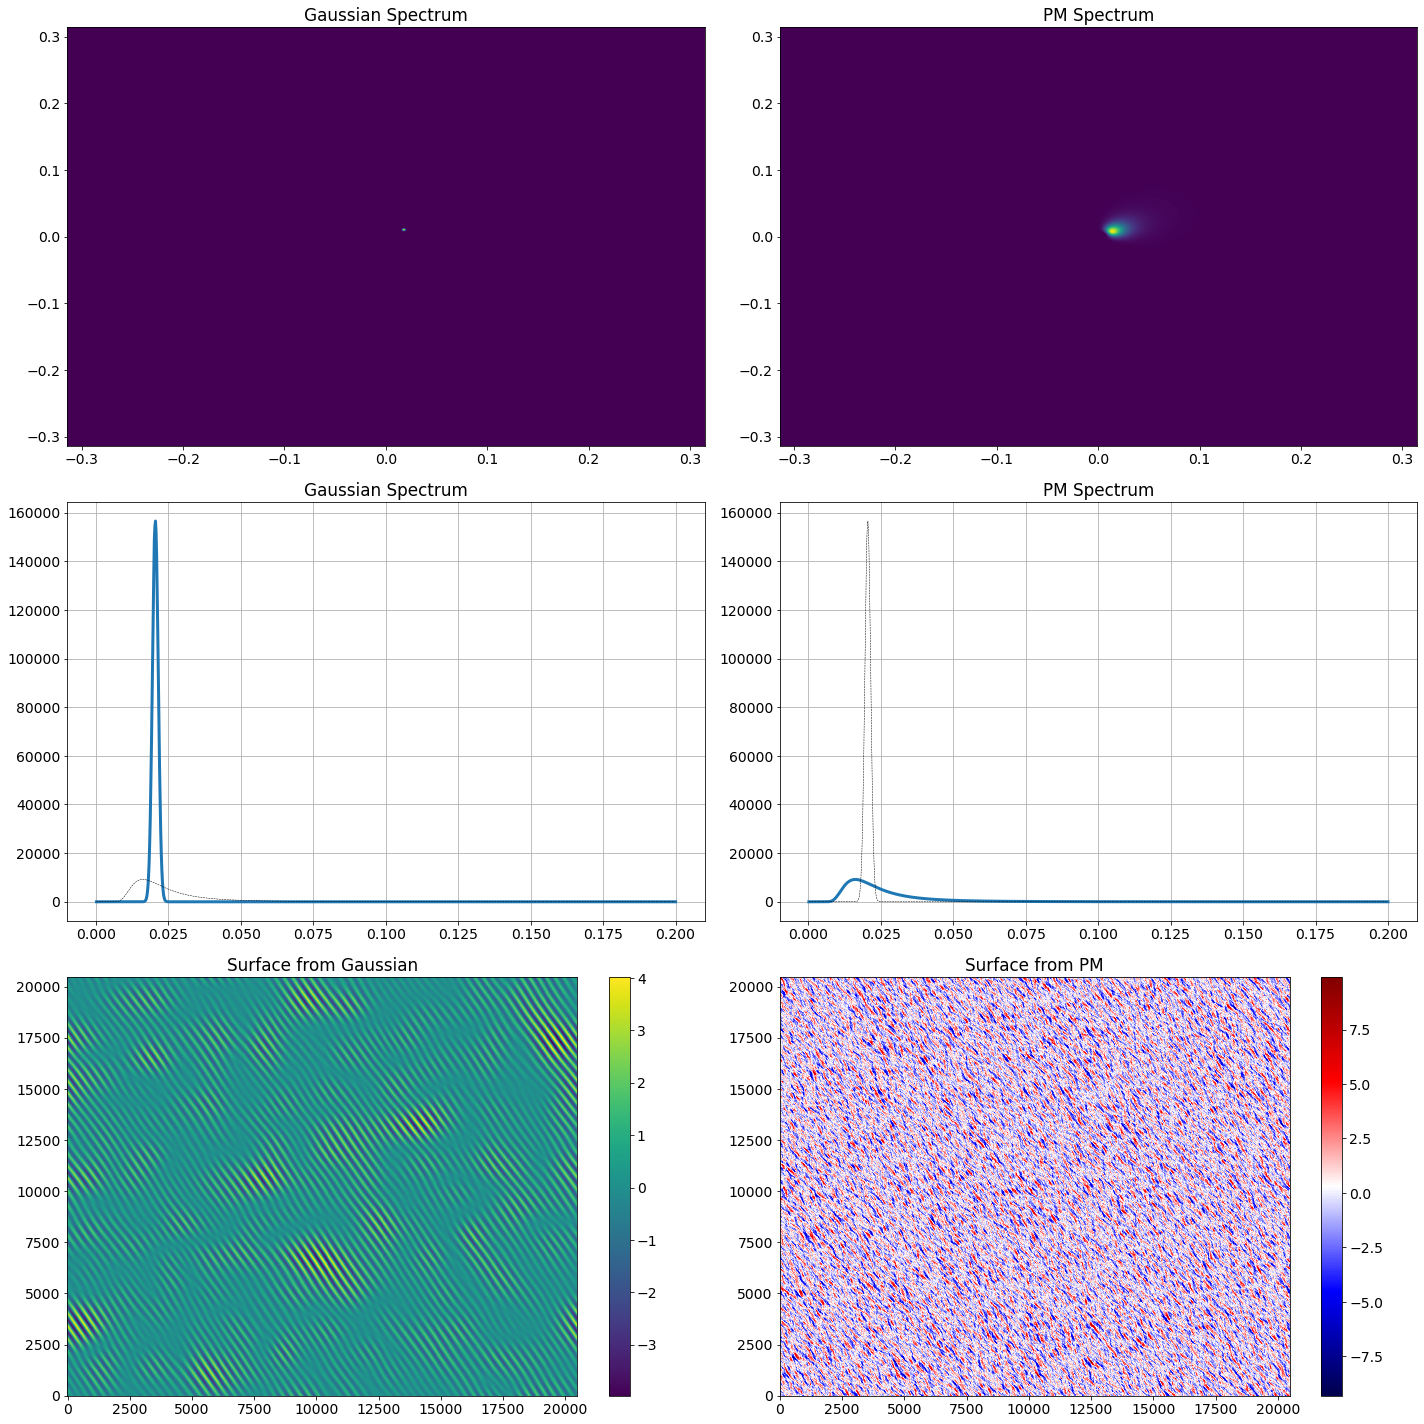

In [43]:
## ----- Draw figure -------------------------------------
fig,axs=plt.subplots(3,2,figsize=(20,20))#,sharey=True,sharex=True)
print(Z1_Gaussian.max())
print(Z1_Gaussian.min())
axs[0][0].pcolormesh(kX,kY,Z1_Gaussian)
axs[0][0].set_title('Gaussian Spectrum')

axs[0][1].pcolormesh(kX,kY,Z1_PM)
axs[0][1].set_title('PM Spectrum')

axs[1][0].plot(k,Z1k_Gaussian,linewidth=3)
axs[1][0].plot(k,Z1k_PM,'--k',linewidth=0.5)
axs[1][0].grid(True)
axs[1][0].set_title('Gaussian Spectrum')

axs[1][1].plot(k,Z1k_PM,linewidth=3)
axs[1][1].plot(k,Z1k_Gaussian,'--k',linewidth=0.5)
axs[1][1].grid(True)
axs[1][1].set_title('PM Spectrum')

im=axs[2][0].pcolormesh(X,Y,S1_Gaussian,cmap='viridis',norm = mcolors.Normalize(vmin=S1_Gaussian.min(), vmax=S1_Gaussian.max()))
axs[2][0].set_title('Surface from Gaussian')
_=plt.colorbar(im,ax=axs[2][0])

im=axs[2][1].pcolormesh(X,Y,S1_PM,cmap='seismic',norm = mcolors.Normalize(vmin=S1_PM.min(), vmax=S1_PM.max()))
axs[2][1].set_title('Surface from PM')
_=plt.colorbar(im,ax=axs[2][1])
plt.tight_layout()

73


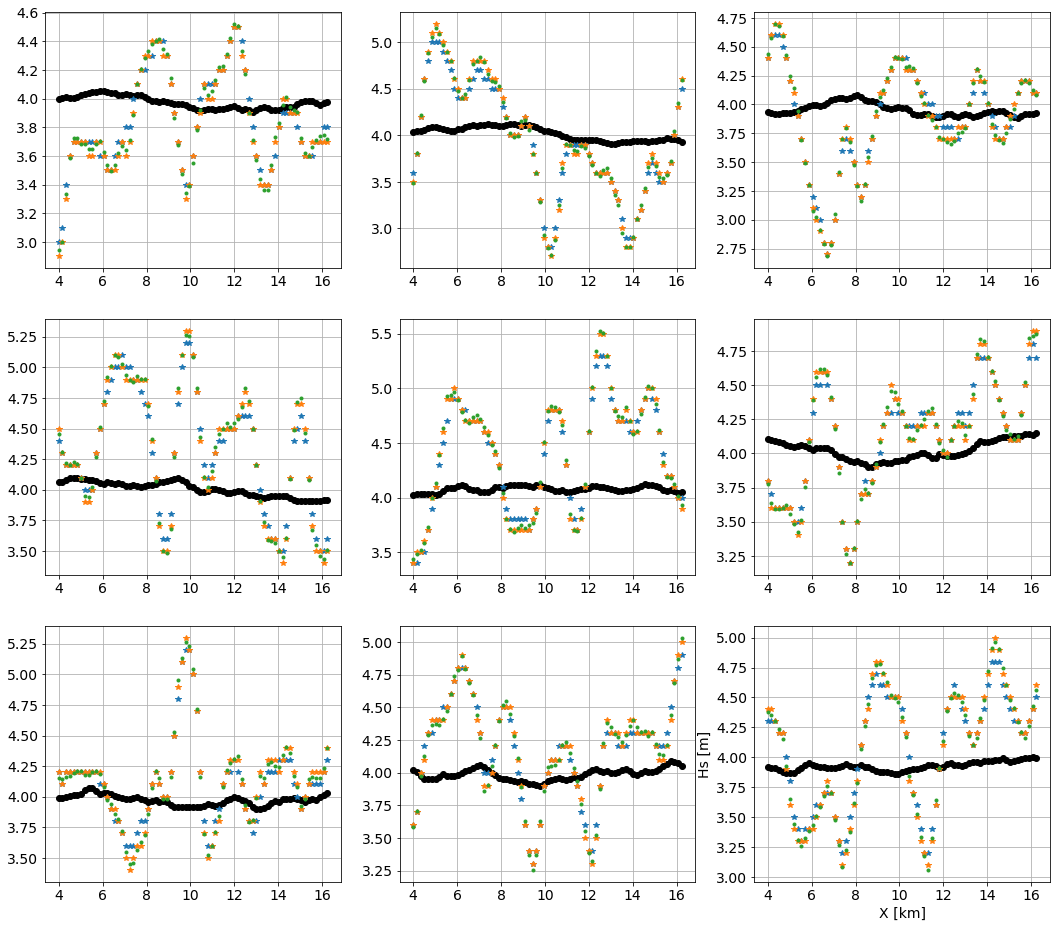

In [19]:
freq_satsampl=40 # freq for waveforms
v_sat=7000 # satellite v
nsy=512
alti_sat=560000 # altitude of satellite CFOSAT

isplot_steps=0
# --- edges for range windows ------------
ne = 51
edges = np.linspace(0,20,ne)
dr = edges[1]-edges[0]
Apix = np.pi*2*alti_sat*dr / (dx**2)
# --- Hs vector --------------------------
nHs=251
Hsm = np.linspace(0,25,nHs)

normG = mcolors.Normalize(vmin=S1_Gaussian.min(), vmax=S1_Gaussian.max())
scalarMapG = cmx.ScalarMappable(norm=normG, cmap='seismic')

radi=4000   # radius of footprint
nxa=np.floor(radi/dx).astype(int) # size of radius of footprint in pixel
footprint=np.ones((2*nxa+1,2*nxa+1))
[Xa,Ya]=np.meshgrid(dx*np.arange(-nxa,nxa+1), dy*np.arange(-nxa,nxa+1))
dist_ground = (Xa**2+Ya**2)
footprint[dist_ground > radi**2]=np.nan

di=np.floor((v_sat/freq_satsampl)/dx).astype(int) # distance between footprint centers, in pixels (v_sat/freq_satsampl = dsitance in m)
nsamp=np.floor((nx-2*nxa)/di).astype(int) # Nb of samples


nbsurfk=9

# --- initialisation of Hs bases ----------------------

Hsalt=np.zeros((nsamp,nbsurfk))
Hs_retrack=np.zeros((nsamp,nbsurfk))
Hs_retrack2=np.zeros((nsamp,nbsurfk))
Hs_retrack3=np.zeros((nsamp,nbsurfk))
Xalt=np.zeros((nsamp,1))
waveforms=np.zeros((nsamp,ne-1))
wfr=np.zeros((nsamp,2))
print(nsamp)
# fig,axs = plt.subplots(10,8,figsize=(20,40))
ny_mid = (ny//2)

wfm_ref, Hsm_ref, edges = generate_wvform_database(len(edges),nHs,edges_max=edges[-1])
colors = plt.cm.seismic(np.linspace(0,1,11))
normHsref = mcolors.Normalize(vmin=0, vmax=Hsm_ref[25*10])
scalarMapHsref = cmx.ScalarMappable(norm=normHsref, cmap='seismic')

PATH = '/home/mdecarlo/PROJETS/CFOSAT_processing/ex_2/'

fig2,axs2=plt.subplots(3,3,figsize=(18,16))
for ik in range(nbsurfk):
    S1_Gaussian,X,Y= surface_from_Z1kxky(Z1_Gaussian,kX,kY)

    for isamp in range(nsamp):
        ialt=(nxa+isamp*di).astype(int)
        Xalt[isamp] = X[ialt]
        surf=S1_Gaussian[ny_mid-nxa:ny_mid+nxa+1,ialt-nxa:ialt+nxa+1]*footprint
        # to have distance to satellite = range
        r=np.sqrt(Xa**2+Ya**2+(alti_sat-surf)**2)-alti_sat+10
        r[dist_ground > radi**2]=np.nan
        counts,_=np.histogram(r,bins=edges)
        Hs_retrack[isamp,ik],dist,Hs_retrack2[isamp,ik],Hs_retrack3[isamp,ik] = simple_retracking_process(counts,edges) 
        waveforms[isamp,:]=counts
        Hsalt[isamp,ik] = 4*np.nanstd(surf.flatten())#/np.sqrt(np.mean(footprint))
    #     axs[isamp//8][isamp%8].plot(edges[:-1],wfm_ref[0,:]*Apix,'-b')
    #     axs[isamp//8][isamp%8].plot(edges[:-1],wfm_ref[-1,:]*Apix,'-r')
    #     axs[isamp//8][isamp%8].plot(edges[:-1],counts,'*')
        if ik==0:
            isplot_steps = 1
        else:
            isplot_steps = 0
        isplot_steps = 0
        if isplot_steps:
            fig,axs=plt.subplots(1,3,figsize=(18,6))
            axs[0].pcolormesh(Xa,Ya,surf,cmap='seismic',norm = normG)
            _=plt.colorbar(scalarMapG,ax=axs[0],label='surface')
            axs[0].axis('equal')

#             print('R min = ',r[np.isfinite(r)].min(), ' and R max = ',r[np.isfinite(r)].max())
            normR = mcolors.Normalize(vmin=r[np.isfinite(r)].min(), vmax=r[np.isfinite(r)].max())
            scalarMapR = cmx.ScalarMappable(norm=normR, cmap='jet')
            axs[1].pcolormesh(Xa,Ya,r,cmap='jet',norm = normR)
            _=plt.colorbar(scalarMapR,ax=axs[1],label='range')
            axs[1].axis('equal')

            for k in range(11):
                axs[2].plot(edges[:-1],wfm_ref[k*25,:]*Apix,'-',color=colors[k])
            axs[2].plot(edges[:-1],counts,'ok')
            _=plt.colorbar(scalarMapHsref,ax=axs[2],label='Hs ref [m]')
            axs[2].grid(True)
            axs[2].set_ylim((-0.5,21000))
            plt.tight_layout()

            plt.savefig(PATH+'waveform_footprint_'+f'{isamp:02d}'+'.png')
            plt.close(fig)
    #     axs[isamp//8][isamp%8].plot(Hsm_ref,dist,'*')
    #     axs[isamp//8][isamp%8].pcolormesh(Xa,Ya,surf)
    
# plt.figure(figsize=(16,6))
    axs2[ik//3,ik%3].plot(Xalt/1000,Hsalt[:,ik],'ok',label='Hs from std of surf')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack[:,ik],'*',label='Hs from min dist')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack2[:,ik],'*',label='Hs from min dist 1 iter')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack3[:,ik],'.',label='Hs from min dist 1 iter + polyfit')
    axs2[ik//3,ik%3].grid(True)
    plt.xlabel('X [km]')
    plt.ylabel('Hs [m]')
#     axs[ik//3,ik%3].legend()
plt.savefig(PATH+'Hsalt_vs_retrack_various_SGaussian_ex2.png')
# Hs_retrack25 = Hs_retrack

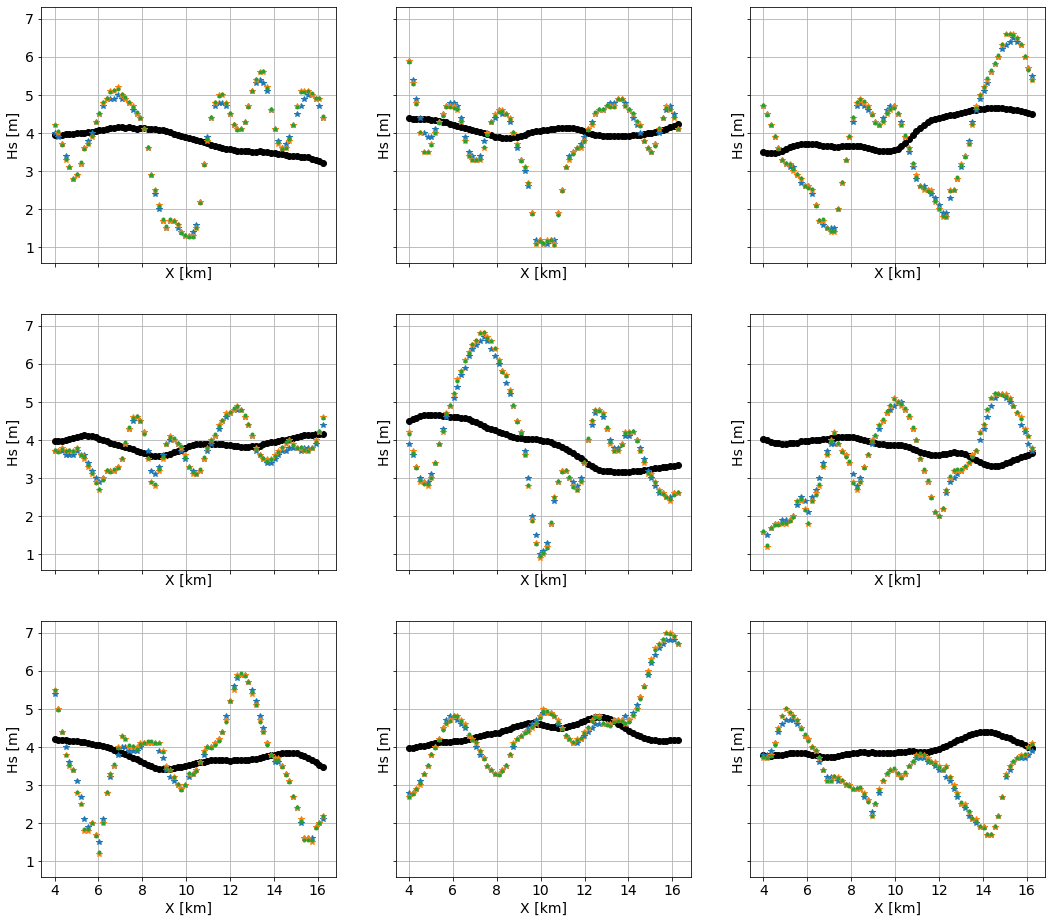

In [11]:
fig2,axs2=plt.subplots(3,3,figsize=(18,16),sharey=True,sharex=True)
for ik in range(nbsurfk):
    axs2[ik//3,ik%3].plot(Xalt/1000,Hsalt[:,ik],'ok',label='Hs from std of surf')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack[:,ik],'*',label='Hs from min dist')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack2[:,ik],'*',label='Hs from min dist 1 iter')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack3[:,ik],'.',label='Hs from min dist 1 iter + polyfit')
    axs2[ik//3,ik%3].grid(True)
    axs2[ik//3,ik%3].set_xlabel('X [km]')
    axs2[ik//3,ik%3].set_ylabel('Hs [m]')
    
plt.savefig(PATH+'Hsalt_vs_retrack_various_SGaussian2.png')

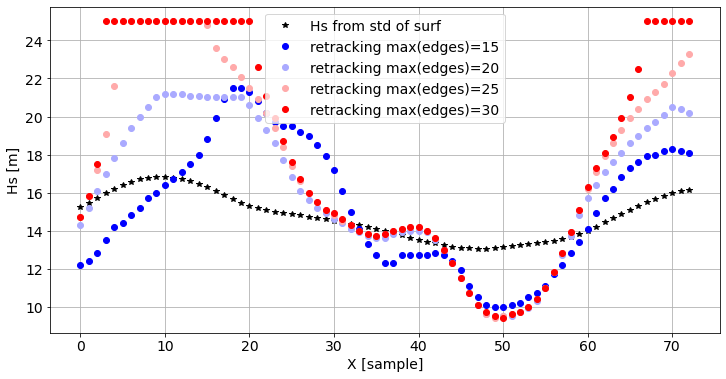

In [96]:
plt.figure(figsize=(12,6))
plt.plot(Hsalt,'*k',label='Hs from std of surf ')
colors = plt.cm.bwr(np.linspace(0,1,4))
plt.plot(Hs_retrack15,'o',color=colors[0],label='retracking max(edges)=15')
plt.plot(Hs_retrack20,'o',color=colors[1],label='retracking max(edges)=20')
plt.plot(Hs_retrack25,'o',color=colors[2],label='retracking max(edges)=25')
plt.plot(Hs_retrack30,'o',color=colors[3],label='retracking max(edges)=30')
plt.grid(True)
plt.xlabel('X [sample]')
plt.ylabel('Hs [m]')
plt.legend()
plt.savefig(PATH+'Hsalt_vs_various_retrack.png')


In [7]:
def simple_retracking_process(wfm,edges,nHs=251,alti_sat=560000,dx=10,offset=10):
    # wfm, Hsm, edges = generate_wvform_database(ne,nHs,edges_max=20,Hs_max=25)
    wfm_ref, Hsm_ref, edges = generate_wvform_database(len(edges),nHs,edges_max=edges[-1],offset=10)
    dr = edges[1]-edges[0]
    Apix = np.pi*2*alti_sat*dr / (dx**2) # The area of a ring, in terms of pixels 

    testwf=np.broadcast_to(wfm,(nHs,len(wfm)))
    dist=np.sum((Apix*wfm_ref-testwf)**2,axis=1)
    Imin=np.argmin(dist)
    Hs0=Hsm_ref[Imin]
    
    KK=np.where((edges > offset-Hs0/2) & (edges < offset+Hs0/2))[0]
    dist2=np.sum((Apix*wfm_ref[:,KK]-testwf[:,KK])**2,axis=1)
    Imin1=np.argmin(dist2)
    Hs1=Hsm_ref[Imin1]
    
    p = np.polyfit(Hsm_ref[Imin1-2:Imin1+3],dist2[Imin1-2:Imin1+3],2)
    Hs2=-p[1]/(2*p[0])

    
    return Hs0, dist,Hs1,Hs2

In [6]:
## Generate waveforms database
def generate_wvform_database(ne,nHs,edges_max=20,Hs_max=25,offset=10):
    edges=np.linspace(0,edges_max,ne)
    dr=edges[1]-edges[0]                  # range vector
    Hsm=np.linspace(0,Hs_max,nHs)
    wfm=np.zeros((nHs,ne-1))
    for k in range(nHs):
        wfm[k,:]=0.5+0.5*sps.erf((edges[:-1]+0.5*dr-offset) / (0.25*np.sqrt(2)*Hsm[k]))
        
    return wfm, Hsm, edges

In [72]:
Hs_retrack, dist= simple_retracking_process(waveforms[0,:],edges,nHs=251,alti_sat=560000,dx=10)

(251, 50)
(251, 50)
(251,)


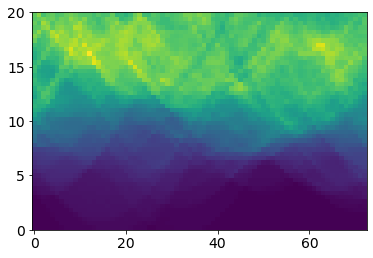

In [70]:
plt.figure()
plt.pcolormesh(np.arange(nsamp),edges[:-1]+0.5*dr,waveforms.T)


In [55]:
print(r[np.isfinite(r)].max())
print(r[np.isfinite(r)].min())

560024.202695912
559989.8799936043


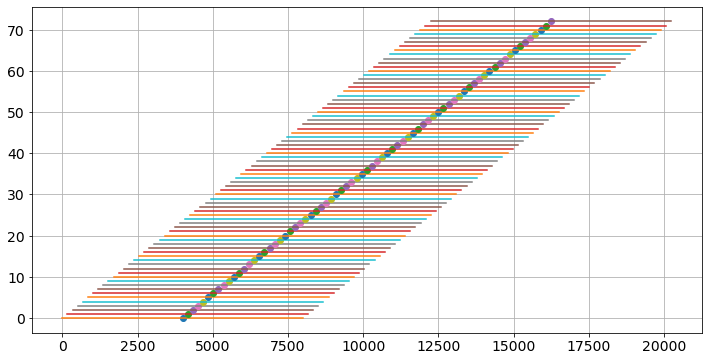

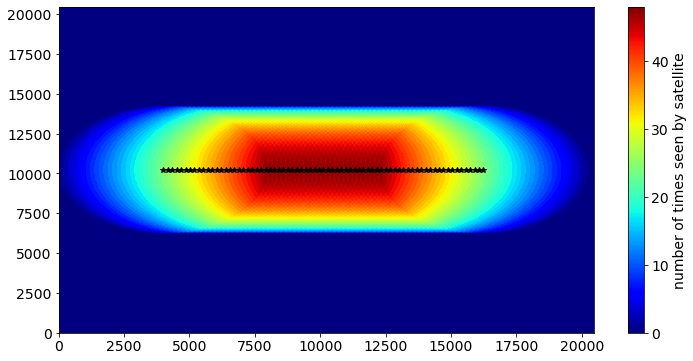

In [41]:
plt.figure(figsize=(12,6))
for isamp in range(nsamp):
    ialt=(nxa+isamp*di).astype(int)
    Xalt = X[ialt]
    Xalt_rad = X[ialt-nxa:ialt+nxa+1]
    plt.plot(Xalt,isamp,'o')
    plt.plot(Xalt_rad,isamp*np.ones(Xalt_rad.shape),'-')
plt.grid(True)



nb_times_seen = np.zeros(S1_Gaussian.shape)
for isamp in range(nsamp):
    ialt=(nxa+isamp*di).astype(int)
    Xalt = X[ialt]
    nb_times_seen[ialt-nxa:ialt+nxa+1,ny_mid-nxa:ny_mid+nxa+1] = nb_times_seen[ialt-nxa:ialt+nxa+1,ny_mid-nxa:ny_mid+nxa+1] +footprint

plt.figure(figsize=(12,6))
im=plt.pcolormesh(X,Y,nb_times_seen.T,cmap='jet')
plt.colorbar(im,label='number of times seen by satellite')
Yalt=Y[ny_mid]
for isamp in range(nsamp):
    ialt=(nxa+isamp*di).astype(int)
    Xalt = X[ialt]
    plt.plot(Xalt,Yalt,'*k')

In [76]:
print('nx, ny = ',nx,' , ',ny)
print('X, Y = ',np.shape(X),' , ',np.shape(Y))
print('maxX, maxY = ',X.max(),' , ',Y.max())
print('kX0, kY0 = ',np.shape(np.unique(kX)),' , ',np.shape(kY0))
print('kX, kY = ',np.shape(kX),' , ',np.shape(kY))
print('shape Z1 = ',np.shape(Z1_PM))
print('shape rg =  ',np.shape(rg))#,' , ',np.shape(dky))
# ny = Z1.shape[0]
# nx = Z1.shape[1]
print('dkx = ',dkx,' =?= ',kX0[1] - kX0[0])
print('dx = ',dx,' =?= ',np.floor(2*np.pi/((kX0[1] - kX0[0])*nx)))
dx2 = (2*np.pi/((kX0[1] - kX0[0])*nx))
print('dkx = ',dkx,' =?= ',kX0[1] - kX0[0],' =?= ',2*np.pi/(dx2*nx))
print(kp)

nx, ny =  2048  ,  2048
X, Y =  (2048,)  ,  (2048,)
maxX, maxY =  20470  ,  20470
kX0, kY0 =  (2048,)  ,  (2048,)
kX, kY =  (2048, 2048)  ,  (2048, 2048)
shape Z1 =  (2048, 2048)
shape rg =   (2048, 2048)
dkx =  0.00030679615757712823  =?=  0.0003067961575771161
dx =  10  =?=  10.0
dkx =  0.00030679615757712823  =?=  0.0003067961575771161  =?=  0.0003067961575771161
0.01006075885537153


kx2D[0,0]= 0.0
ky2D[0,0]= 0.0
1023.0


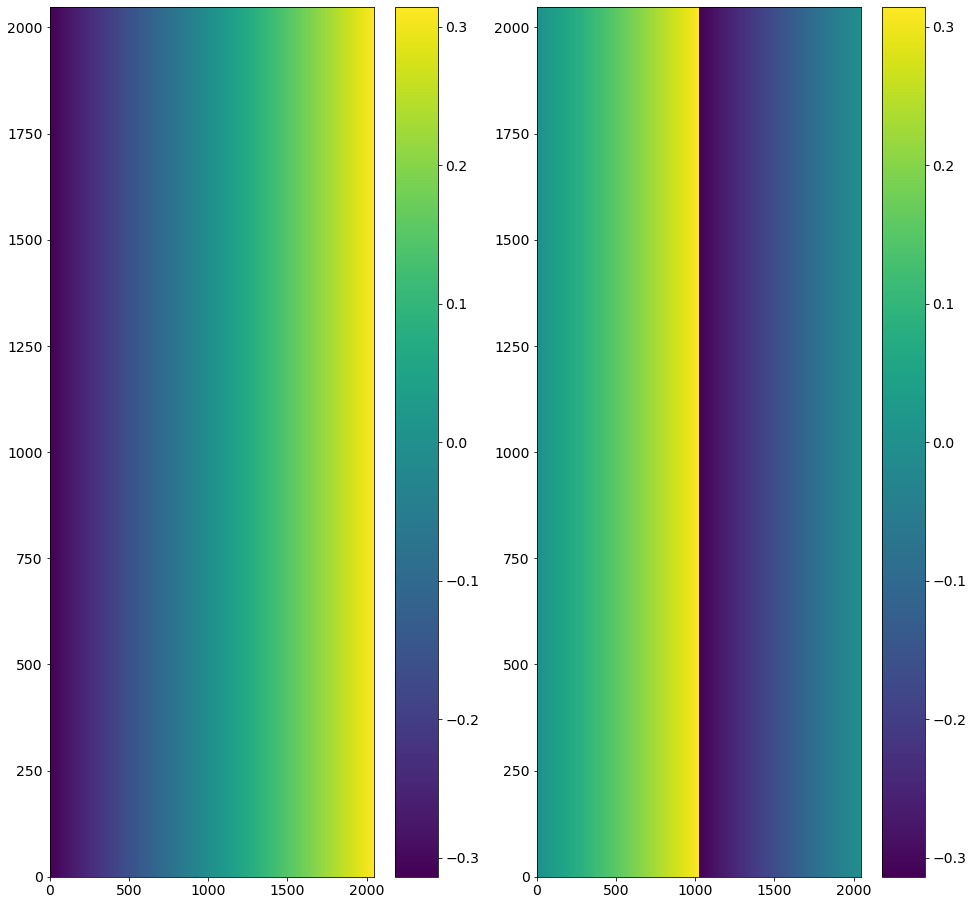

In [23]:
ky2D=np.roll(kY,(-int(shy),-int(shx)),axis=(0,1)) # checks that ky2D(1,1)=0 ... 
kx2D=np.roll(kX,(-int(shy),-int(shx)),axis=(0,1))# -int(shx),axis=1) # checks that kx2D(1,1)=0 ... 
print('kx2D[0,0]=',kx2D[0,0])
print('ky2D[0,0]=',ky2D[0,0])
print(shx)
fig,axs=plt.subplots(1,2,figsize=(16,16))

im=axs[0].pcolormesh(kX,cmap='viridis',norm = mcolors.Normalize(vmin=kX.min(), vmax=kX.max()))
plt.colorbar(im,ax=axs[0])

im=axs[1].pcolormesh(kx2D,cmap='viridis',norm = mcolors.Normalize(vmin=kx2D.min(), vmax=kx2D.max()))
plt.colorbar(im,ax=axs[1])

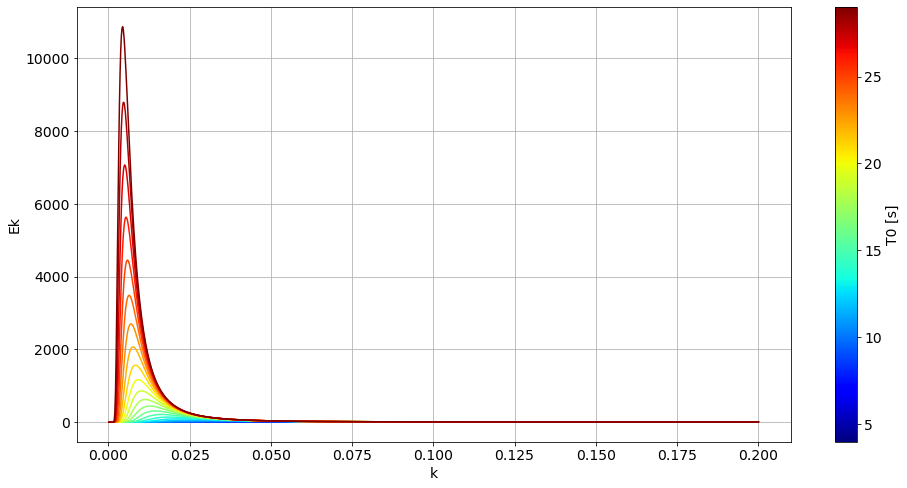

In [6]:
# ---------- Pierson Moskowitz Spectrum depending on T0

T0s = np.arange(4,30)
k=np.linspace(0.0002,0.2,nk)

plt.figure(figsize=(16,8))
colors = plt.cm.jet(np.linspace(0,1,len(T0s)))
cNorm  = mcolors.Normalize(vmin=T0s[0], vmax=T0s[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='jet')
for iT0 in range(len(T0s)):
    Ek = PM_spectrum_k(k,1/T0s[iT0],D=D)
    plt.plot(k,Ek,'-',color=colors[iT0])
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Ek')
plt.colorbar(scalarMap,label='T0 [s]')

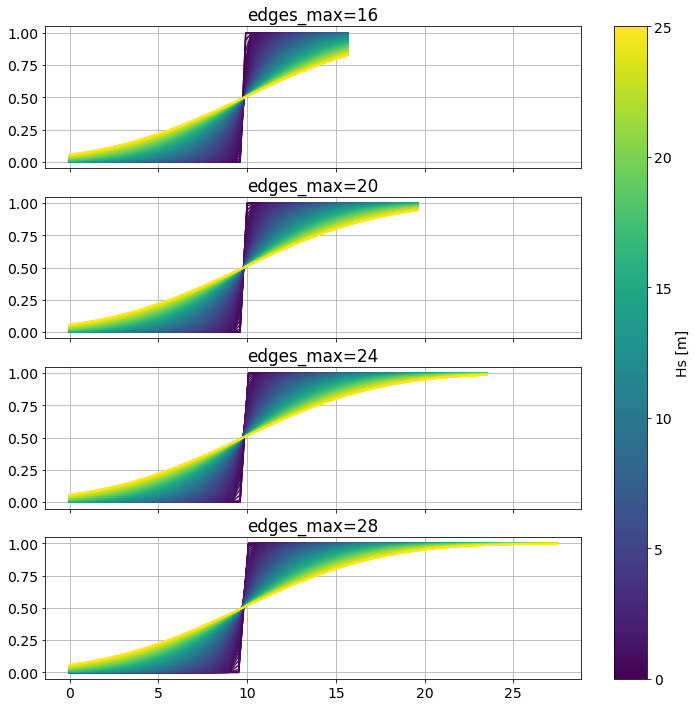

In [24]:
colors = plt.cm.viridis(np.linspace(0,1,nHs))
cNorm  = mcolors.Normalize(vmin=Hsm.min(), vmax=Hsm.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='viridis')

fig,axs=plt.subplots(4,1,figsize=(12,12),sharex=True)
for ned in range(4):
    wfm, Hsm, edges = generate_wvform_database(ne,nHs,edges_max=16+ned*4,Hs_max=25)
    for k in range(nHs):
        _=axs[ned].plot(edges[:-1],wfm[k,:],color=colors[k])
    tit = 'edges_max='+str(16+ned*4)
    axs[ned].set_title(tit)
    axs[ned].grid(True)

_=plt.grid(True)
_=plt.colorbar(scalarMap,label='Hs [m]',ax=axs[:])



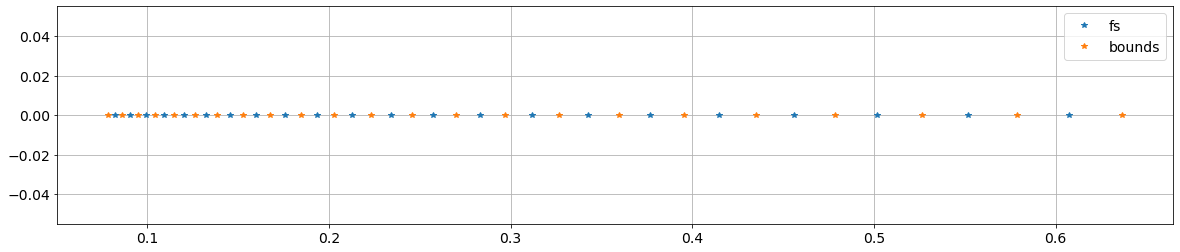

In [82]:
fo = 0.082038
xfr = 1.1
n = np.arange(0,22)
fn = fo *xfr**n
fn2 = np.zeros((len(fn)+1))
fn2[0] = fn[0]/np.sqrt(xfr)
fn2[1:] = fn * np.sqrt(xfr)
plt.figure(figsize=(20,4))
plt.plot(fn,np.zeros(fn.shape),'*',label='fs')
plt.plot(fn2,np.zeros(fn2.shape),'*',label='bounds')
plt.grid(True)
plt.legend()

<xarray.Dataset>
Dimensions:                           (n_mcycles: 25549, n_swath_0: 256, n_swath_1: 755, n_swath_2: 933, n_swath_3: 2771, n_swath_4: 2639, n_swath_5: 3215, n_beam: 6, n_tim: 2, n_beam0: 1, n_swath_0_cor: 512)
Dimensions without coordinates: n_mcycles, n_swath_0, n_swath_1, n_swath_2, n_swath_3, n_swath_4, n_swath_5, n_beam, n_tim, n_beam0, n_swath_0_cor
Data variables: (12/80)
    echo_l1a_0                        (n_mcycles, n_swath_0) float32 ...
    echo_l1a_1                        (n_mcycles, n_swath_1) float32 ...
    echo_l1a_2                        (n_mcycles, n_swath_2) float32 ...
    echo_l1a_3                        (n_mcycles, n_swath_3) float32 ...
    echo_l1a_4                        (n_mcycles, n_swath_4) float32 ...
    echo_l1a_5                        (n_mcycles, n_swath_5) float32 ...
    ...                                ...
    reliable_swath_0                  (n_swath_0) float32 ...
    reliable_swath_1                  (n_swath_1) float32 ...
    reliable_swath_2                  (n_swath_2) float32 ...
    reliable_swath_3                  (n_swath_3) float32 ...
    reliable_swath_4                  (n_swath_4) float32 ...
    reliable_swath_5                  (n_swath_5) float32 ...
Attributes: (12/49)
    history:                              none
    institution:                          CNES
    references:                           DDI CFOSAT - Ref. CF_GSFR-ICD-1094-...
    title:                                SWIM_L1A____product
    Conventions:                          CF-1.7
    date_created:                         2020-12-23T11:08:50Z
    ...                                   ...
    nimp:                                 264;97;97;156;186;204
    antenna_rotation_speed:               5.6
    beam_elevation:                       0.000000;2.300000;3.700000;5.550000...
    beam_width:                           1.585000;1.530000;1.740000;1.860000...
    signal_sampling_in_radar_geometry:    0.374741;1.498962;1.498962;0.749481...
    signal_resolution_in_radar_geometry:  0.468426;1.873703;1.873703;0.936851...

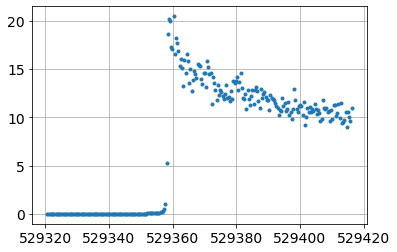

In [28]:
filenc='/home/datawork-cersat-public/provider/cnes/satellite/l1a/cfosat/swim/swi_l1a___/op05/5.1.2/2020/002/CFO_OP05_SWI_L1A____F_20200102T002637_20200102T020004.nc'
ds=xr.open_dataset(filenc,decode_times=False)
plt.plot(ds.isel(n_mcycles=15).radar_range_0,ds.isel(n_mcycles=15).echo_l1a_0,'.')
plt.grid(True)
ds

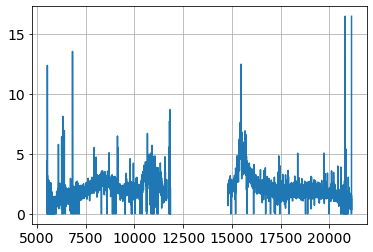

In [37]:
filenc='/home/datawork-cersat-public/provider/cnes/satellite/l2/cfosat/swim/swi_l2____/op05/5.1.2/2020/002/CFO_OP05_SWI_L2_____F_20200102T002637_20200102T020004.nc'
dsL2=xr.open_dataset(filenc,decode_times=False)
plt.plot(dsL2.nadir_swh_native,dsL2.nadir_swh_native)
plt.grid(True)

[   0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.     304.879  681.73   914.637
 1099.258 1257.049 1397.133 1524.397 1641.826 1751.399 1854.51  1952.182
 2045.195 2134.158 2219.558 2301.792 2381.188 2458.021 2532.524 2604.896
 2675.312 2

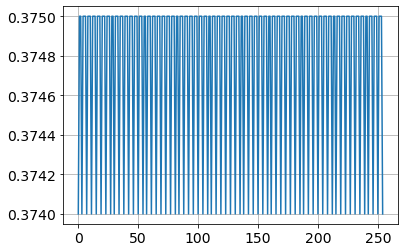

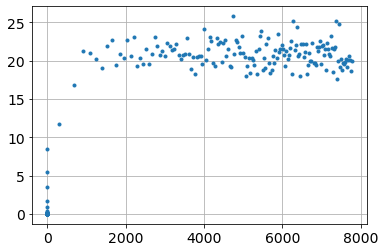

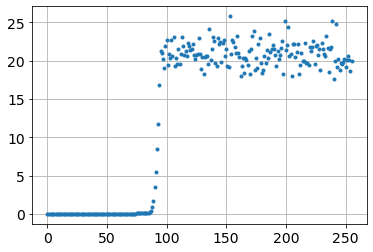

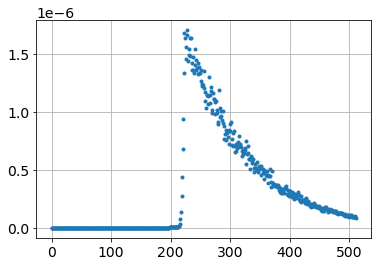

In [41]:
plt.figure()
nbcycle = 16000
plt.plot(np.diff(ds.isel(n_mcycles=nbcycle).radar_range_0))


# plt.plot(ds.isel(n_mcycles=nbcycle).radar_range_0,ds.isel(n_mcycles=nbcycle).echo_l1a_0,'.')
plt.grid(True)
plt.figure()
plt.plot(ds.isel(n_mcycles=nbcycle).ground_range_0,ds.isel(n_mcycles=nbcycle).echo_l1a_0,'.')
plt.grid(True)
print(ds.isel(n_mcycles=nbcycle).ground_range_0.data)

plt.figure()
plt.plot(ds.isel(n_mcycles=nbcycle).echo_l1a_0,'.')
plt.grid(True)

plt.figure()
plt.plot(ds.isel(n_mcycles=nbcycle,n_beam0=0).echo_l1_0,'.')
plt.grid(True)

In [29]:
def spectrum_from_fth_to_kth(Efth,f,th,D=None):
    shEfth = np.shape(Efth)
    if len(shEfth)<2:
        print('Error: spectra should be 2D')
    else:
        if shEfth[0]==shEfth[1]:
            print('Warning: same dimension for freq and theta.\n  Proceed with caution: The computation is done considering Efth = f(f,th)')
        elif (shEfth[1]==len(f)) &(shEfth[0]==len(th)):
            Efth = np.swapaxes(Efth,0,1)
        else:
            print('Error: Efth should have the shape : (f,th)')
    shEfth = np.shape(np.moveaxis(Efth,0,-1))
    k=k_from_f(f,D=D)
    dfdk=dfdk_from_k(k,D=D)
    Ekth = Efth*np.moveaxis(np.broadcast_to(dfdk,shEfth),-1,0)
    return Ekth, k, th

def spectrum_from_kth_to_kxky(Ekth,k,th):
    shEkth = np.shape(Ekth)
    if len(shEkth)<2:
        print('Error: spectra should be 2D')
    else:
        if shEkth[0]==shEkth[1]:
            print('Warning: same dimension for k and theta.\n  Proceed with caution: The computation is done considering Ekth = f(k,th)')
        elif (shEkth[1]==len(k)) &(shEkth[0]==len(th)):
            Ekth = np.swapaxes(Ekth,0,1)
        else:
            print('Error: Efth should have the shape : (k,th)')
    shEkth2 = np.shape(np.moveaxis(Ekth,0,-1)) # send k-axis to last -> in order to broadcast k along every dim
    shEkth2Dkth = Ekth.shape[0:2] # get only shape k,th for the broadcast of the dimensions kx,ky

    if np.max(th)>100:
        th=th*np.pi/180
    kx = np.moveaxis(np.broadcast_to(k,shEkth2Dkth[::-1]),-1,0) * np.cos(np.broadcast_to(th,shEkth2Dkth))
    ky = np.moveaxis(np.broadcast_to(k,shEkth2Dkth[::-1]),-1,0) * np.sin(np.broadcast_to(th,shEkth2Dkth))
    Ekxky = Ekth/np.moveaxis(np.broadcast_to(k,shEkth2),-1,0)
    return Ekxky, kx, ky

def spectrum_from_fth_to_kxky(Efth,f,th,D=None):
    shEfth = np.shape(Efth)
    if len(shEfth)<2:
        print('Error: spectra should be 2D')
    else:
        if shEfth[0]==shEfth[1]:
            print('Warning: same dimension for freq and theta.\n  Proceed with caution: The computation is done considering Efth = f(f,th)')
        elif (shEfth[1]==len(f)) &(shEfth[0]==len(th)):
            Efth = np.swapaxes(Efth,0,1)
        else:
            print('Error: Efth should have the shape : (f,th)')
    shEfth2 = np.shape(np.moveaxis(Efth,0,-1)) # send f-axis to last -> in order to broadcast f along every dim
    shEfth2Dfth = Efth.shape[0:2] # get only shape f,th for the broadcast of the dimensions kx,ky
    k=k_from_f(f,D=D)
    dfdk=dfdk_from_k(k,D=D)
    if np.max(th)>100:
        th=th*np.pi/180
    
    kx = np.moveaxis(np.broadcast_to(k,shEfth2Dfth[::-1]),-1,0) * np.cos(np.broadcast_to(th,shEkth2Dkth))
    ky = np.moveaxis(np.broadcast_to(k,shEfth2Dfth[::-1]),-1,0) * np.sin(np.broadcast_to(th,shEkth2Dkth))
    Ekxky = Efth * np.moveaxis(np.broadcast_to(dfdk /k,shEfth2),-1,0)
    return Ekxky, kx, ky

def spectrum_to_kxky(typeSpec,Spec,ax1,ax2,D=None):
    if typeSpec==0: # from f,th
        Ekxky, kx, ky = spectrum_from_fth_to_kxky(Spec,ax1,ax2,D=D)
    elif typeSpec==1: # from k,th
        Ekxky, kx, ky = spectrum_from_kth_to_kxky(Spec,ax1,ax2)
    else:
        print('Error ! typeSpec should be 0 = (f,th) or 1 = (k,th)')
        Ekxky = Spec
        kx = ax1
        ky = ax2
    return Ekxky, kx, ky

# spectrum Ekth => Ekxky

In [2]:
nx=2048
ny=2048
altif=40 # freq for waveforms
v=7000
nsy=512
noise = 0
shx = np.floor(nx/2-1)
shy = np.floor(ny/2-1)

ne = 51
edges = np.linspace(0,20,ne)

dr = edges[1]-edges[0]

nHs=251
Hsm = np.linspace(0,25,nHs)


dx = 10
dy = 10
dkx = 2*np.pi/(dx*nx)
dky = 2*np.pi/(dy*ny)


In [3]:
wfm=np.zeros((nHs,ne-1))
for k in range(nHs):
    wfm[k,:]=0.5+0.5*sps.erf((edges[:-1]+0.5*dr-10) / (0.25*np.sqrt(2)*Hsm[k]))

(-0.045000000000000005, 0.9450000000000001, -0.05, 1.05)

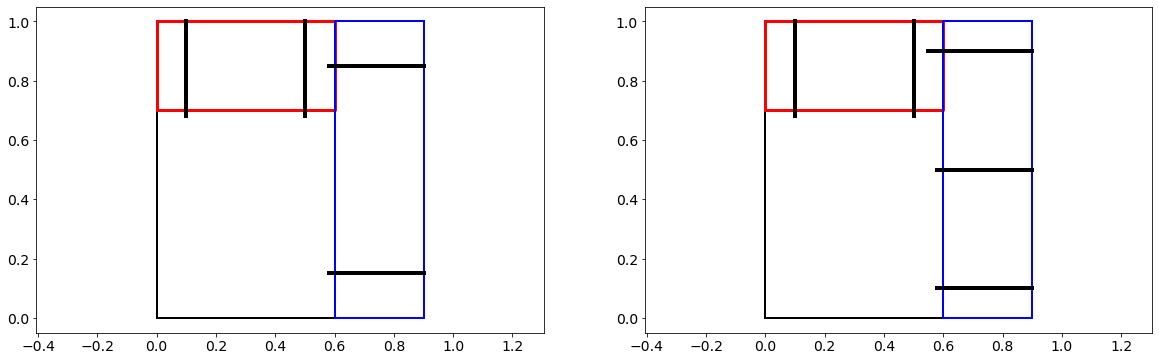

In [18]:
Xmurs = [0,0.9,0.9,0,0]
Ymurs = [0,0,1,1,0]

Xplanche1 = [0,0.6,0.6,0,0]
Yplanche1 = [1-0.3,1-0.3,1,1,1-0.3]

Xplanche2 = [0.6,0.9,0.9,0.6,0.6]
Yplanche2 = [0,0,1,1,0]

Xcons1 = [0.1,0.1]
Ycons1 = [0.68,1]

Xcons2 = [0.5,0.5]
Ycons2 = [0.68,1]

Xcons3 = [0.58,0.9]
Ycons3 = [0.15,0.15]

Xcons4 = [0.58,0.9]
Ycons4 = [0.85,0.85]

Xcons3bis = [0.58,0.9]
Ycons3bis = [0.1,0.1]

Xcons5bis = [0.58,0.9]
Ycons5bis = [0.5,0.5]

Xcons4bis = [0.55,0.9]
Ycons4bis = [0.9,0.9]


fig,axs = plt.subplots(1,2,figsize=(20,6))

axs[0].plot(Xmurs,Ymurs,'-k',linewidth=2)
axs[0].plot(Xplanche1,Yplanche1,'-r',linewidth=3)
axs[0].plot(Xplanche2,Yplanche2,'-b',linewidth=2)
axs[0].plot(Xcons1,Ycons1,'-k',linewidth=4)
axs[0].plot(Xcons2,Ycons2,'-k',linewidth=4)
axs[0].plot(Xcons3,Ycons3,'-k',linewidth=4)
axs[0].plot(Xcons4,Ycons4,'-k',linewidth=4)


axs[0].axis('equal')

axs[1].plot(Xmurs,Ymurs,'-k',linewidth=2)
axs[1].plot(Xplanche1,Yplanche1,'-r',linewidth=3)
axs[1].plot(Xplanche2,Yplanche2,'-b',linewidth=2)
axs[1].plot(Xcons1,Ycons1,'-k',linewidth=4)
axs[1].plot(Xcons2,Ycons2,'-k',linewidth=4)
axs[1].plot(Xcons3bis,Ycons3bis,'-k',linewidth=4)
axs[1].plot(Xcons4bis,Ycons4bis,'-k',linewidth=4)
axs[1].plot(Xcons5bis,Ycons5bis,'-k',linewidth=4)



axs[1].axis('equal')


In [ ]:
Xcons5bis
